# SVCCA & CKA Report

This notebook reads the consolidated CSV outputs from `build_analysis_dataset.py` and produces:
- Pairwise heatmaps (CKA & SVCCA) per (epoch, layer)
- Scatter plots (CKA vs SVCCA)
- Summary tables (mean/median similarity per layer/epoch)

> Requirements: `pandas`, `numpy`, `matplotlib` (no seaborn).

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Set the directory where build_analysis_dataset.py wrote outputs
OUTDIR = os.getenv("REPORT_OUTDIR", "/workspace/out")

pairwise_csv = os.path.join(OUTDIR, "pairwise_scores.csv")
summary_csv  = os.path.join(OUTDIR, "trial_summary.csv")

print("Using OUTDIR:", OUTDIR)
print("Expecting:", pairwise_csv, "and", summary_csv)

df = pd.read_csv(pairwise_csv)
try:
    df_summary = pd.read_csv(summary_csv)
except Exception:
    df_summary = None

print("Loaded rows:", len(df))
if df_summary is not None:
    print("Loaded trial_summary with rows:", len(df_summary))

Using OUTDIR: /workspace/out
Expecting: /workspace/out/pairwise_scores.csv and /workspace/out/trial_summary.csv
Loaded rows: 185
Loaded trial_summary with rows: 16


In [17]:
# Discover available epochs and layers
epochs = sorted(df['epoch'].unique().tolist())
layers = sorted(df['layer'].unique().tolist())
metrics = sorted(df['metric'].unique().tolist())

print("Epochs:", epochs)
print("Layers:", layers)
print("Metrics:", metrics)

Epochs: [1]
Layers: ['conv1']
Metrics: ['CKA', 'SVCCA']


In [18]:
# Helper to build a square matrix for a given (epoch, layer, metric)
def matrix_for(epoch, layer, metric):
    d = df[(df['epoch']==epoch) & (df['layer']==layer) & (df['metric']==metric)]
    # trials are in pairs i<j; build symmetric matrix
    trials = sorted(set(d['trial_i']).union(set(d['trial_j'])))
    idx = {t:i for i,t in enumerate(trials)}
    M = np.eye(len(trials))
    for _, row in d.iterrows():
        i, j = idx[row['trial_i']], idx[row['trial_j']]
        M[i,j] = M[j,i] = float(row['score'])
    return trials, M

# Choose a default to visualize (last epoch, a mid-layer)
E = epochs[-1]
L = layers[min(2, len(layers)-1)]
print("Default selection -> epoch:", E, "layer:", L)

Default selection -> epoch: 1 layer: conv1


In [19]:
# Heatmap helper (matplotlib only, one chart per figure, no explicit colors)
def show_heatmap(M, labels, title):
    plt.figure(figsize=(6,5))
    plt.imshow(M, aspect='auto')
    plt.xticks(range(len(labels)), labels, rotation=90)
    plt.yticks(range(len(labels)), labels)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

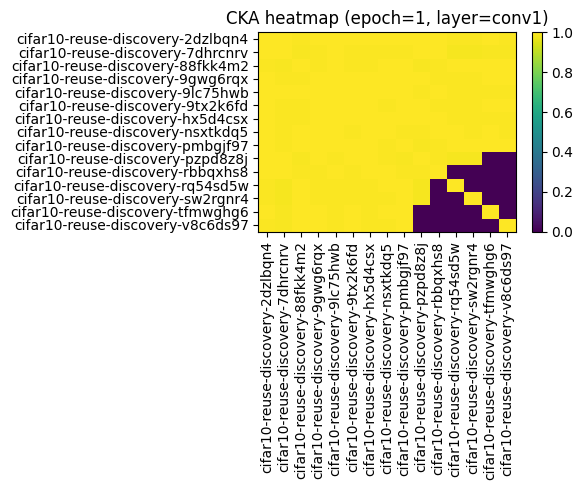

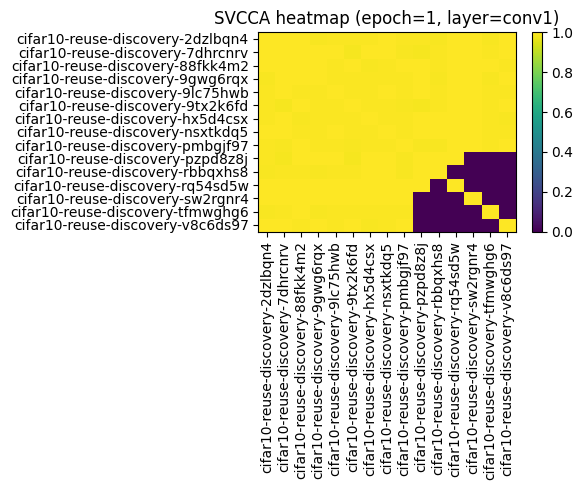

In [20]:
# Plot CKA & SVCCA heatmaps for (E, L)
trials, M_cka = matrix_for(E, L, 'CKA')
_,       M_sv = matrix_for(E, L, 'SVCCA')

show_heatmap(M_cka, trials, f"CKA heatmap (epoch={E}, layer={L})")
show_heatmap(M_sv,  trials, f"SVCCA heatmap (epoch={E}, layer={L})")

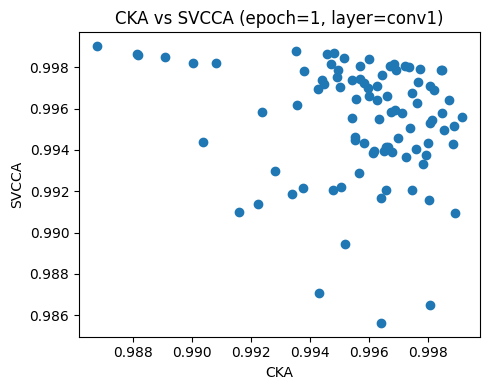

metric,trial_i,trial_j,CKA,SVCCA
0,cifar10-reuse-discovery-2dzlbqn4,cifar10-reuse-discovery-7dhrcnrv,0.996607,0.996603
1,cifar10-reuse-discovery-2dzlbqn4,cifar10-reuse-discovery-88fkk4m2,0.995028,0.997025
2,cifar10-reuse-discovery-2dzlbqn4,cifar10-reuse-discovery-9gwg6rqx,0.998918,0.990960
3,cifar10-reuse-discovery-2dzlbqn4,cifar10-reuse-discovery-9lc75hwb,0.998005,0.994344
4,cifar10-reuse-discovery-2dzlbqn4,cifar10-reuse-discovery-9tx2k6fd,0.997933,0.993769


In [21]:
# Scatter CKA vs SVCCA for (E, L)
d = df[(df['epoch']==E) & (df['layer']==L)]
dd = d.pivot_table(index=['trial_i','trial_j'], columns='metric', values='score').reset_index()
dd = dd.dropna()

plt.figure(figsize=(5,4))
plt.scatter(dd['CKA'], dd['SVCCA'])
plt.xlabel("CKA")
plt.ylabel("SVCCA")
plt.title(f"CKA vs SVCCA (epoch={E}, layer={L})")
plt.tight_layout()
plt.show()

dd.head()

In [22]:
# Summary tables
summary_by_layer = df.groupby(['layer','metric'])['score'].agg(['mean','median','std','count']).reset_index()
summary_by_epoch = df.groupby(['epoch','metric'])['score'].agg(['mean','median','std','count']).reset_index()

summary_by_layer.sort_values(['metric','mean'], ascending=[True, False], inplace=True)
summary_by_epoch.sort_values(['metric','epoch'], ascending=[True, True], inplace=True)

print("Summary by layer (top 10 rows):")
display(summary_by_layer.head(10))

print("Summary by epoch:")
display(summary_by_epoch)

Summary by layer (top 10 rows):


,layer,metric,mean,median,std,count
0,conv1,CKA,0.995621,0.996271,0.002663,93
1,conv1,SVCCA,0.995404,0.995891,0.002815,92


Summary by epoch:


,epoch,metric,mean,median,std,count
0,1,CKA,0.995621,0.996271,0.002663,93
1,1,SVCCA,0.995404,0.995891,0.002815,92
